In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import pymongo
import pickle
import bson
import subprocess
import glob

# Other external scripts
import lst1_mongodb_example
import utils

## Some definitions and parameters

In [2]:
client_tcu  = pymongo.MongoClient("lst101-int:27017")
client_caco = pymongo.MongoClient("lst101-int:27018")

compute_obs_db_entries = False
compute_auxiliar_dictionaries = False
compute_entry_counting_slurm = False

tstart = datetime.fromisoformat("2024-02-25-00:00:00")
tstop  = datetime.fromisoformat("2024-04-01-00:00:00")
# tstart = datetime.fromisoformat("2024-03-11-12:00:00")
# tstop  = datetime.fromisoformat("2024-03-12-08:00:00")

directory_tmp_dicts = "./objects/tmp/"

dict_caco_states = {
    0 : "OFF", 1 : "DATA_MONITORING", 2 : "MONITORED", 3 : "SAFE", 4 : "STANDBY",
    5 : "READY", 6 : "OBSERVING", 7 : "TPOINT", 8 : "UNDEFINED", 9 : "TRANSITIONAL", 10 : "ERROR"
}
dict_caco_state_colors = {
    0 : "k", 1 : "darkviolet", 2 : "darkviolet", 3 : "lime", 4 : "gold",
    5 : "c", 6 : "blue", 7 : "darkblue", 8 : "r", 9 : "darkorange", 10 : "r"
}

## Functions to show the properties of TCU and CaCo databases

In [3]:
def get_TCU_properties():
    return subprocess.run("python lst1_mongodb_example.py --list-available", shell=True)

def get_CaCo_collections():
    client_caco = pymongo.MongoClient("lst101-int:27018")
    all_databases = np.sort(client_caco.list_database_names())
    print(f"--- {'':^40s} ---")
    print(f"--- {'Available CaCo databases and collections':^40s} ---")
    print(f"--- {'':^40s} ---")
    for database in all_databases:
        print(f"\n--- {f'Database - {database}':^40s} ---")
        all_collections = np.sort(client_caco[database].list_collection_names())
        for i, collection in enumerate(all_collections):
            print(f"{i:4d} : {collection}")

def get_CaCo_properties():
    client_caco = pymongo.MongoClient("lst101-int:27018")
    caco_db = client_caco.CACO
    dict_caco_names = {}
    all_collections = np.sort(caco_db.list_collection_names())
    for coll_name in all_collections:
        coll = caco_db[coll_name]
        if coll not in ["STATE", "RUN_INFORMATION"] and "week" in coll_name:
        
            print(f"\n--- {f'Collection - {coll_name}':^40s} ---")
            names = coll.distinct("name")
            
            dict_caco_names[coll_name.replace("week", "min")] = names
            for i,n in enumerate(names):
                print(f"{i:4.0f} : {n}")

# get_TCU_properties()
# get_CaCo_collections()
# get_CaCo_properties()

### Getting the observations of TCU and CaCo

In [4]:
%%time
def get_records(mongo_client, database_name, collection_name, query):
    collection = mongo_client[database_name][collection_name]
    response   = collection.find(query)
    records = tuple(doc for doc in response)    
    return records
query = None

if compute_obs_db_entries:
    
    # Reading TCU database
    print("Reading TCU database")
    records_obs_tcu  = get_records(client_tcu, "lst1_obs_summary", "camera", query)
    # Reading CaCo database
    print("Reading CaCo database")
    records_obs_caco = get_records(client_caco, "CACO", "RUN_INFORMATION", query)  
    
    with open("objects/records_obs_tcu.pkl", "wb") as f:
        pickle.dump(records_obs_tcu, f, pickle.HIGHEST_PROTOCOL)
    with open("objects/records_obs_caco.pkl", "wb") as f:
        pickle.dump(records_obs_caco, f, pickle.HIGHEST_PROTOCOL)

else:
    with open("objects/records_obs_tcu.pkl", "rb") as f:
        records_obs_tcu = pickle.load(f)
    with open("objects/records_obs_caco.pkl", "rb") as f:
        records_obs_caco = pickle.load(f)

CPU times: user 781 ms, sys: 961 ms, total: 1.74 s
Wall time: 2.2 s


### Getting CaCo states timestamps and then getting timespans

In [5]:
%%time
variable_caco_state = "CameraControl_FSM_state"

states_caco_entries = lst1_mongodb_example.get_entries(client_tcu, variable_caco_state, astropy_time=False, tstart=tstart, tstop=tstop)
states_date_tcu, states_value_tcu = np.array(states_caco_entries["time"]), np.array(states_caco_entries["value"])
states_value_tcu_str = np.array([dict_caco_states[v] for v in states_value_tcu])

CPU times: user 640 ms, sys: 38.5 ms, total: 678 ms
Wall time: 16.4 s


In [6]:
# Creating a timespan dictionary for each key
if compute_auxiliar_dictionaries:

    dict_timespans = {}
    for key in dict_caco_states.keys():
        dict_timespans[key] = {"tstart" : [], "tstop" : [], "tspan" : []}
    
    before_state = 3
    initial_time = tstart
    
    for i in range(len(states_value_tcu))[:]:
        actual_state = states_value_tcu[i]
        # print(i, actual_state)
    
        if actual_state != before_state:
            final_time = states_date_tcu[i]
    
            dict_timespans[before_state]["tstart"].append(initial_time)
            dict_timespans[before_state]["tstop"].append(final_time)
            dict_timespans[before_state]["tspan"].append((final_time - initial_time).total_seconds())
    
            initial_time = states_date_tcu[i]
            
        before_state = actual_state

    dict_timespans[actual_state]["tstart"].append(states_date_tcu[-1])
    dict_timespans[actual_state]["tstop"].append(tstop)
    dict_timespans[actual_state]["tspan"].append((tstop - states_date_tcu[-1]).total_seconds())  
    
    with open("objects/dict_timespans.pkl", "wb") as f:
        pickle.dump(dict_timespans, f, pickle.HIGHEST_PROTOCOL)

else:
    with open("objects/dict_timespans.pkl", "rb") as f:
        dict_timespans = pickle.load(f)

dict_timespans[3]["tstart"] = dict_timespans[3]["tstart"][:-1]
dict_timespans[3]["tstop"] = dict_timespans[3]["tstop"][:-1]
dict_timespans[3]["tspan"] = dict_timespans[3]["tspan"][:-1]

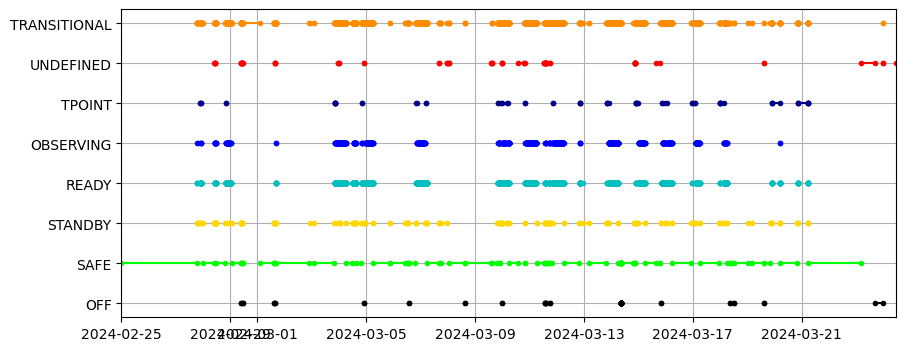

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))

for key in dict_caco_states.keys():
    for j in range(len(dict_timespans[key]["tstart"])):
    
        ax.plot(
            [dict_timespans[key]["tstart"][j], dict_timespans[key]["tstop"][j]], 
            [dict_caco_states[key], dict_caco_states[key]],
            marker=".", ls="-", color=dict_caco_state_colors[key]
        )
ax.set_xlim(states_date_tcu[0], states_date_tcu[-1])
ax.grid()
plt.show()

#### Getting all TCU property names

In [8]:
%%time
if compute_auxiliar_dictionaries:
    string_properties = subprocess.check_output("python lst1_mongodb_example.py --list-available", shell=True).decode("utf-8").split("\n")
    all_tcu_properties = np.array([s.split(" : ")[-1] for s in string_properties[3:-1]])
    
    camera_related_tcu_properties = []
    non_camera_properties_prefix = ["AMC_", "AuxControl_", "CDM2_", "DriveControl_", "SecurityBrokerControl_"]
    
    for p in all_tcu_properties:
        flag_camera = True
        for non_p in non_camera_properties_prefix:
            if non_p in p:
                flag_camera = False
                break
        if flag_camera:
            camera_related_tcu_properties.append(p)
    
    print(f"There are {len(all_tcu_properties)} TCU properties in total")
    print(f"There are {len(camera_related_tcu_properties)} TCU Camera-related properties")
    
    with open("objects/camera_related_tcu_properties.pkl", "wb") as f:
        pickle.dump(camera_related_tcu_properties, f, pickle.HIGHEST_PROTOCOL)
else:
    with open("objects/camera_related_tcu_properties.pkl", "rb") as f:
        camera_related_tcu_properties = pickle.load(f)

CPU times: user 2.91 ms, sys: 2.94 ms, total: 5.85 ms
Wall time: 14.5 ms


### Here we are doing the trick of extracting the size of a chunk for each property of the TCU database

In [9]:
%%time
if compute_auxiliar_dictionaries:
    
    dict_tcu_property_bytes = {}
    for p in camera_related_tcu_properties:
        dict_tcu_property_bytes[p] = 0
        
    # Taking the main collections and chunks pointers
    property_collection = client_tcu['bridgesmonitoring']['properties']
    chunk_collection = client_tcu['bridgesmonitoring']['chunks']
    
    for ip, _property in enumerate(camera_related_tcu_properties):
        
        descriptors = property_collection.find({'property_name': _property})
    
        for desc in descriptors:
            query = {'pid': desc['_id']}
            query.update({"begin": {"$gte": tstart}, "end": {"$lte": tstop}})
    
            chunks = chunk_collection.find(query)
            for chunk in chunks:
    
                bson_data = bson.BSON.encode(chunk)
                size_in_bytes = len(bson_data)
    
                dict_tcu_property_bytes[_property] = size_in_bytes
                
                break
        print(f"{ip/len(camera_related_tcu_properties)*100:2.3f}% Extracting bytes of {_property}")

    with open("objects/dict_tcu_property_bytes.pkl", "wb") as f:
        pickle.dump(dict_tcu_property_bytes, f, pickle.HIGHEST_PROTOCOL)
else:
    with open("objects/dict_tcu_property_bytes.pkl", "rb") as f:
        dict_tcu_property_bytes = pickle.load(f)

CPU times: user 1.65 ms, sys: 1.79 ms, total: 3.44 ms
Wall time: 16.7 ms


In [160]:

sorted_properties = sorted(dict_tcu_property_bytes.items(), key=lambda item: item[1], reverse=True)

# Print the sorted properties and values
for property, value in sorted_properties:
    if "ECC" in property:
        print(f'{value*1e-3:10.3f} kb -> {property}')

     8.267 kb -> ECC_Monitoring_Front_fans_FanTachymeter_
     4.111 kb -> ECC_Monitoring_Sensors_TemperatureSensors_TemperatureSensor_
     1.343 kb -> ECC_Monitoring_PDB_CurrentSensors_CurrentSupply400V_L
     1.343 kb -> ECC_Monitoring_PDB_Power_ApparentPower400V_L
     1.280 kb -> ECC_Monitoring_PDB_VoltageSensors_VoltageSupply400V_L
     0.902 kb -> ECC_Monitoring_PDB_Power_ActivePower400V_L
     0.902 kb -> ECC_Monitoring_PDB_Power_PowerFactor_L
     0.902 kb -> ECC_Monitoring_PDB_Power_ReactivePower400V_L
     0.776 kb -> ECC_Monitoring_PDB_PhaseToPhase400VSensors_PhaseToPhase400V_L
     0.578 kb -> ECC_Monitoring_PDB_Cosinus400V
     0.552 kb -> ECC_Monitoring_Sensors_WaterPressureSensors_WaterPressureSensor_
     0.381 kb -> ECC_Monitoring_PDB_Power_ReactiveCapacitivePowerUPS
     0.381 kb -> ECC_Monitoring_PDB_Power_ReactivePowerUPS
     0.352 kb -> ECC_Monitoring_Spares_Analog_AI_
     0.344 kb -> ECC_Monitoring_Spares_Digital_DI_
     0.317 kb -> ECC_Monitoring_PDB_VoltageS

#### Then sending a job per property to slurm that stores the dicts for the byte contribution

In [10]:
tmp_dicts_files = glob.glob(directory_tmp_dicts + "*.pkl")
print(f"Found {len(tmp_dicts_files)} .pkl files in: {directory_tmp_dicts}")

done_properties = [f.split("dict_property_")[-1][:-4] for f in tmp_dicts_files]
camera_related_tcu_properties_filtered = [p for p in camera_related_tcu_properties if p not in done_properties]
print(f"Then the new properties that are not already computed are {len(camera_related_tcu_properties_filtered)}")

# for s in dict_caco_states.keys():
#     print(f"For state {s} : {len(dict_timespans[s]['tstart'])}")

Found 498 .pkl files in: ./objects/tmp/
Then the new properties that are not already computed are 0


In [11]:
%%time
if compute_entry_counting_slurm:
    array_properties = camera_related_tcu_properties_filtered[:]
    for i, prop in enumerate(array_properties):
        print(f"{i}/{len(array_properties)}")
    
        slurm_command = f"sbatch -p short -J get_db_properties --wrap='python script_get_property_size.py {prop}'"
        result = subprocess.run(slurm_command, shell=True, capture_output=True, text=True)
        
        print(result.stdout)
        if result.stderr:
            print(f"Error: {result.stderr}")
    
        # # In order to test it locally
        # !python script_get_property_size.py $prop

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.06 µs


## Reading the result dictionaries to fill a main dict

In [12]:
%%time
# Defining the main dictionary
DICT = {
    "size_total_merged" : None,
    "bins_joint" : None, ###
    "bins_joint_width" : None, ###
    "states" : {},
}

for state in dict_caco_states.keys():
    tmp_dict = {
    "timespans" : dict_timespans[state], ###
    "bins" : np.array([*dict_timespans[state]["tstart"], *dict_timespans[state]["tstop"][-1:]]), ###
    "size_total" : None, ###
    "size_total_joint" : None, ###
    "properties" : {},
    }
    for prop in camera_related_tcu_properties:
        tmp_dict["properties"][prop] = {
            "size" : None, ###
            "size_joint" : None, ###
        }

    DICT["states"][state] = tmp_dict

# Filling some of the parts
all_start_end_times = []
for state in dict_caco_states.keys():
    for t in dict_timespans[state]["tstart"]:
        all_start_end_times.append(t)
    for t in dict_timespans[state]["tstop"]:
        all_start_end_times.append(t)
        
bins_joint = np.sort(np.unique(all_start_end_times))
DICT["bins_joint"] = bins_joint
DICT["bins_joint_width"] = [b.total_seconds() for b in np.diff(bins_joint)]

print(f"The number of bins we have is {len(bins_joint) - 1}")

dict_results = {}
for prop in camera_related_tcu_properties:
    with open(directory_tmp_dicts + f"dict_property_{prop}.pkl", "rb") as f:
        tmp_dict = pickle.load(f)
    dict_results[prop] = tmp_dict


for state in dict_caco_states.keys():
    for prop in camera_related_tcu_properties:
        time_widths = np.array(DICT["states"][state]["timespans"]["tspan"])
        DICT["states"][state]["properties"][prop]["size"] = dict_results[prop][state]["size"]
    
for state in dict_caco_states.keys():
    tmp_total_size = np.zeros(len(DICT["states"][state]["timespans"]["tspan"]))
    for prop in camera_related_tcu_properties:
        tmp_total_size += DICT["states"][state]["properties"][prop]["size"]

    DICT["states"][state]["size_total"] = tmp_total_size

The number of bins we have is 4121
CPU times: user 293 ms, sys: 221 ms, total: 514 ms
Wall time: 9.43 s


## Create a mask for the binning

In [13]:
dict_mask_bins = {}
for state in dict_caco_states.keys():
    bins_state = DICT["states"][state]["bins"]
    mask_state = np.repeat(None, len(bins_joint) - 1)
    index = 0

    for mi, m in enumerate(bins_joint[:-1]):
        if m in bins_state and index != len(bins_state) - 1:
            mask_state[mi] = index
            index += 1

    dict_mask_bins[state] = mask_state

## Calculating the joint distributions

In [14]:
%%time
def bins_merger(counts, mask, bins_joint):
    counts_joint = []
    for mi in range(len(mask)):
        if mask[mi] == None:
            counts_joint.append(0.0)
        else:
            # print(mask[mi])
            counts_joint.append(counts[mask[mi]])
    return np.array(counts_joint)

for state in dict_caco_states.keys():
    total_size = []
    size_total = DICT["states"][state]["size_total"]
    DICT["states"][state]["size_total_joint"] = bins_merger(size_total, dict_mask_bins[state], bins_joint)
    
    for prop in camera_related_tcu_properties:
        size_prop = DICT["states"][state]["properties"][prop]["size"]
        DICT["states"][state]["properties"][prop]["size_joint"] = bins_merger(size_prop, dict_mask_bins[state], bins_joint)

tmp_merged_size = np.zeros(len(bins_joint) - 1)
for state in dict_caco_states.keys():
    tmp_merged_size += DICT["states"][state]["size_total_joint"]

DICT["size_total_merged"] = tmp_merged_size

CPU times: user 4.11 s, sys: 88.3 ms, total: 4.2 s
Wall time: 4.19 s


In [15]:
def points_to_hist(size, bins_joint):
    x, y = [], []
    for i, b in enumerate(bins_joint):
        if i == 0 or i == len(bins_joint) - 1:
            x.append(b)    
        else:
            x.append(b)
            x.append(b)
    
        if i < len(bins_joint) - 1:
            y.append(size[i])
            y.append(size[i])
    return x, y

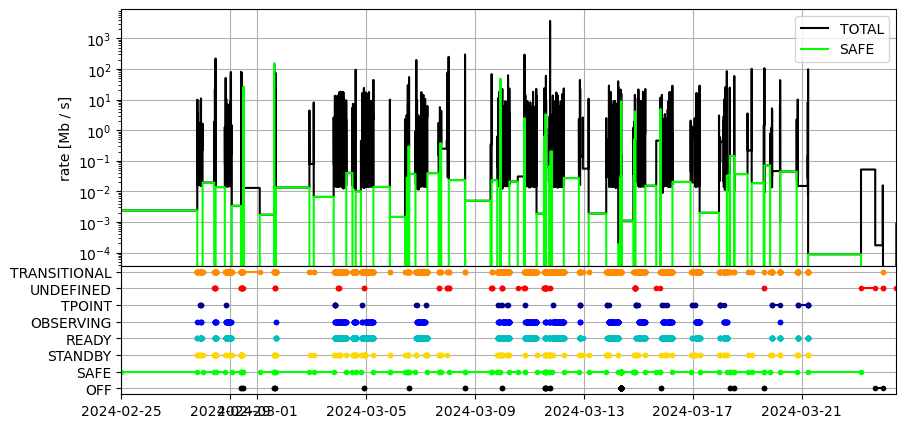

In [16]:
size = DICT["size_total_merged"] / DICT["bins_joint_width"] * 1e-6
x, y = points_to_hist(size, bins_joint)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax.plot(x , y, color="k", label="TOTAL", ls="-")

for s in [3]: #dict_caco_states:
    size = DICT["states"][s]["size_total_joint"] / DICT["bins_joint_width"] * 1e-6
    x, y = points_to_hist(size, bins_joint)
    ax.plot(x, y, color=dict_caco_state_colors[s], label=dict_caco_states[s])

for key in dict_caco_states.keys():
    for j in range(len(dict_timespans[key]["tstart"])):
        ax2.plot(
            [dict_timespans[key]["tstart"][j], dict_timespans[key]["tstop"][j]], 
            [dict_caco_states[key], dict_caco_states[key]],
            marker=".", ls="-", color=dict_caco_state_colors[key]
        )
plt.subplots_adjust(wspace=0, hspace=0)

ax.legend(loc=1) # loc=(1.01,0))
ax.set_yscale("log")
ax.set_ylabel("rate [Mb / s]")
ax.set_xlim(states_date_tcu[0], states_date_tcu[-1])
ax.grid()
ax2.grid()

plt.show()

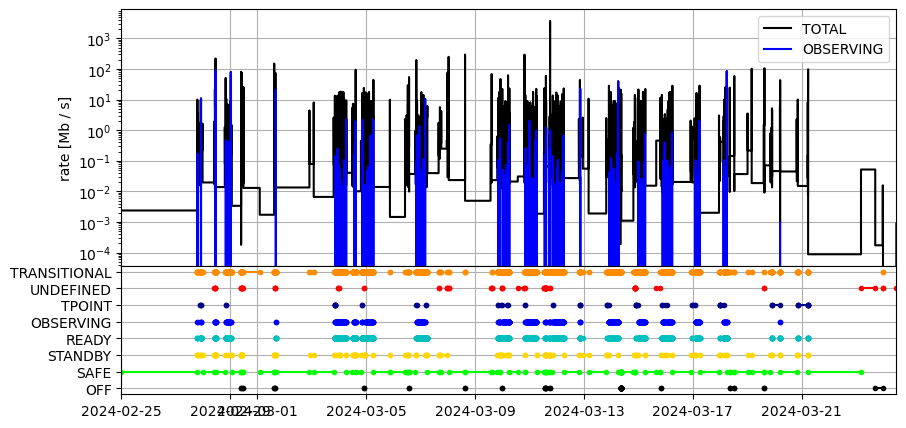

In [17]:
size = DICT["size_total_merged"] / DICT["bins_joint_width"] * 1e-6
x, y = points_to_hist(size, bins_joint)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax.plot(x , y, color="k", label="TOTAL", ls="-")

for s in [6]: #dict_caco_states:
    size = DICT["states"][s]["size_total_joint"] / DICT["bins_joint_width"] * 1e-6
    x, y = points_to_hist(size, bins_joint)
    ax.plot(x, y, color=dict_caco_state_colors[s], label=dict_caco_states[s])

for key in dict_caco_states.keys():
    for j in range(len(dict_timespans[key]["tstart"])):
        ax2.plot(
            [dict_timespans[key]["tstart"][j], dict_timespans[key]["tstop"][j]], 
            [dict_caco_states[key], dict_caco_states[key]],
            marker=".", ls="-", color=dict_caco_state_colors[key]
        )
plt.subplots_adjust(wspace=0, hspace=0)

ax.legend(loc=1) # loc=(1.01,0))
ax.set_yscale("log")
ax.set_ylabel("rate [Mb / s]")
ax.set_xlim(states_date_tcu[0], states_date_tcu[-1])
ax.grid()
ax2.grid()

plt.show()

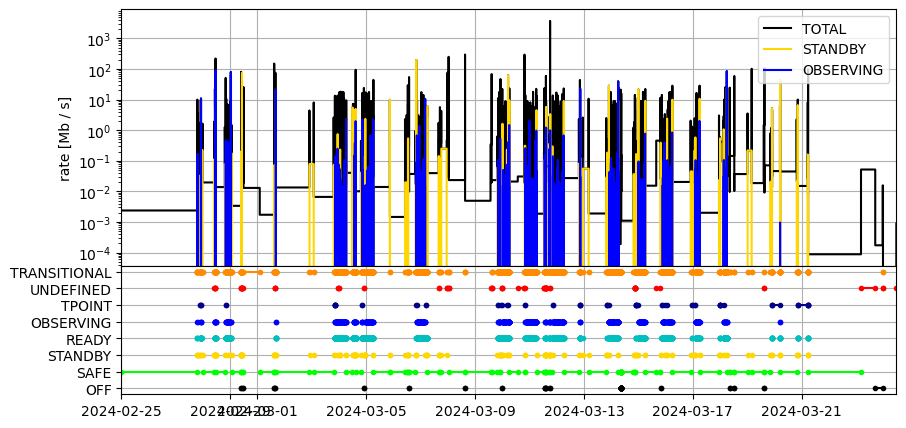

In [166]:
size = DICT["size_total_merged"] / DICT["bins_joint_width"] * 1e-6
x, y = points_to_hist(size, bins_joint)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax.plot(x , y, color="k", label="TOTAL", ls="-")

for s in [4, 6]:
    size = DICT["states"][s]["size_total_joint"] / DICT["bins_joint_width"] * 1e-6
    x, y = points_to_hist(size, bins_joint)
    ax.plot(x, y, color=dict_caco_state_colors[s], label=dict_caco_states[s])

for key in dict_caco_states.keys():
    for j in range(len(dict_timespans[key]["tstart"])):
        ax2.plot(
            [dict_timespans[key]["tstart"][j], dict_timespans[key]["tstop"][j]], 
            [dict_caco_states[key], dict_caco_states[key]],
            marker=".", ls="-", color=dict_caco_state_colors[key]
        )
plt.subplots_adjust(wspace=0, hspace=0)

ax.legend(loc=1) # loc=(1.01,0))
ax.set_yscale("log")
ax.set_ylabel("rate [Mb / s]")
ax.set_xlim(states_date_tcu[0], states_date_tcu[-1])
ax.grid()
ax2.grid()

plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
size = DICT["size_total_merged"] / DICT["bins_joint_width"] * 1e-6
x, y = points_to_hist(size, bins_joint)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax.plot(x , y, color="k", label="TOTAL", ls="-")

for s in [4, 5, 7, 8]:
    size = DICT["states"][s]["size_total_joint"] / DICT["bins_joint_width"] * 1e-6
    x, y = points_to_hist(size, bins_joint)
    ax.plot(x, y, color=dict_caco_state_colors[s], label=dict_caco_states[s])

for key in dict_caco_states.keys():
    for j in range(len(dict_timespans[key]["tstart"])):
        ax2.plot(
            [dict_timespans[key]["tstart"][j], dict_timespans[key]["tstop"][j]], 
            [dict_caco_states[key], dict_caco_states[key]],
            marker=".", ls="-", color=dict_caco_state_colors[key]
        )
plt.subplots_adjust(wspace=0, hspace=0)

ax.legend(loc=1) # loc=(1.01,0))
ax.set_yscale("log")
ax.set_ylabel("rate [Mb / s]")
ax.set_xlim(states_date_tcu[0], states_date_tcu[-1])
ax.grid()
ax2.grid()

plt.show()

In [19]:
suma = 0
for state in dict_caco_states:
    suma += np.sum(DICT["states"][state]["size_total"]) * 1e-9
suma

252.445106164

In [20]:
db = client_tcu['bridgesmonitoring']
db.command("dbstats")

{'db': 'bridgesmonitoring',
 'collections': 4,
 'views': 0,
 'objects': 949724264,
 'avgObjSize': 1253.4169707093006,
 'dataSize': 1190400509992.0,
 'storageSize': 381998526464.0,
 'numExtents': 0,
 'indexes': 6,
 'indexSize': 23278850048.0,
 'scaleFactor': 1.0,
 'fsUsedSize': 885017243648.0,
 'fsTotalSize': 3458653831168.0,
 'ok': 1.0}

In [95]:
TOTAL = 0
TTIME = 0
for s in dict_caco_states:
    rate_hour = np.sum(DICT["states"][s]["size_total"]) / np.sum(DICT["states"][s]["timespans"]["tspan"]) * 1e-6 * 3600
    TOTAL += np.sum(DICT["states"][s]["size_total"])
    TTIME += np.sum(DICT["states"][s]["timespans"]["tspan"]) / 3600
    print(f"For state {dict_caco_states[s]:15} : {rate_hour:10.2f} Mb/hour")

print(f"\nTOTAL:   {TOTAL * 1e-9:.2f} Gb in a average rate of {TOTAL * 1e-6 / TTIME:.2f} Mb/hour")

For state OFF             :    3922.43 Mb/hour
For state DATA_MONITORING :        nan Mb/hour
For state MONITORED       :        nan Mb/hour
For state SAFE            :      73.52 Mb/hour
For state STANDBY         :     773.97 Mb/hour
For state READY           :    1197.83 Mb/hour
For state OBSERVING       :     435.68 Mb/hour
For state TPOINT          :    1108.98 Mb/hour
For state UNDEFINED       :     157.35 Mb/hour
For state TRANSITIONAL    :    1343.78 Mb/hour
For state ERROR           :        nan Mb/hour

TOTAL:   252.45 Gb in a average rate of 296.22 Mb/hour


/tmp/ipykernel_29618/2897989993.py:4: RuntimeWarning: invalid value encountered in scalar divide
  rate_hour = np.sum(DICT["states"][s]["size_total"]) / np.sum(DICT["states"][s]["timespans"]["tspan"]) * 1e-6 * 3600


In [137]:
dict_caco_states

{0: 'OFF',
 1: 'DATA_MONITORING',
 2: 'MONITORED',
 3: 'SAFE',
 4: 'STANDBY',
 5: 'READY',
 6: 'OBSERVING',
 7: 'TPOINT',
 8: 'UNDEFINED',
 9: 'TRANSITIONAL',
 10: 'ERROR'}

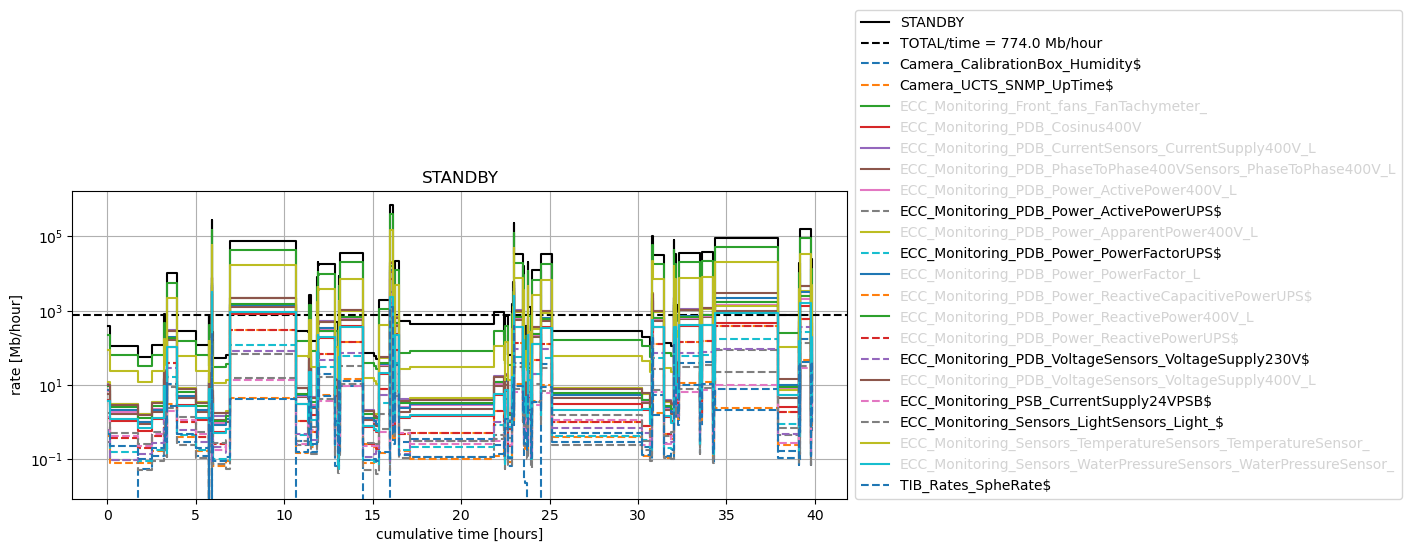

In [225]:
s = 4

cumulative_bins = np.cumsum(DICT["states"][s]["timespans"]["tspan"]) / 3600
size = DICT["states"][s]["size_total"] / DICT["states"][s]["timespans"]["tspan"] * 1e-6 * 3600
sum_size = np.sum(size)
rate_hour = np.sum(DICT["states"][s]["size_total"]) / np.sum(DICT["states"][s]["timespans"]["tspan"]) * 1e-6 * 3600

x, y = points_to_hist(size, cumulative_bins)


fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(x, y, color="k", label=dict_caco_states[s])
plt.axhline(rate_hour, color="k", ls="--", label=f"TOTAL/time = {rate_hour:.1f} Mb/hour")

sizes = []
sumsizes = []
states_fin = []
for prop in camera_related_tcu_properties:
    size = DICT["states"][s]["properties"][prop]["size"] / DICT["states"][s]["timespans"]["tspan"] * 1e-6 * 3600
    sizes.append(size)
    sumsizes.append(np.sum(size))
colors = ["k", "k"]
for i, prop in enumerate(camera_related_tcu_properties):
    if np.sum(sizes[i]) >= np.flip(np.sort(sumsizes))[10]:
    # if np.sum(size) > 0.01 * sum_size:
        x, y = points_to_hist(sizes[i], cumulative_bins)
        ax.plot(x, y, label=f"{prop}")
        states_fin.append(prop)
        if prop in common_props:
            colors.append("lightgray")
        else:
            colors.append("k")
    elif np.sum(sizes[i]) >= np.flip(np.sort(sumsizes))[20]:
    # if np.sum(size) > 0.01 * sum_size:
        x, y = points_to_hist(sizes[i], cumulative_bins)
        ax.plot(x, y, label=f"{prop}$", ls="--")
        states_fin.append(prop)
        if prop in common_props:
            colors.append("lightgray")
        else:
            colors.append("k")

plt.legend(loc=(1.01,0), labelcolor=colors)
plt.yscale("log")
plt.ylabel("rate [Mb/hour]")
plt.xlabel("cumulative time [hours]")
ax.set_title(f"{dict_caco_states[s]}")
ax.grid()

plt.savefig(f"plots/{dict_caco_states[s]}.png", bbox_inches="tight", dpi=300)
plt.show()

In [217]:
colors

['k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'lightgray',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 'k',
 '

In [202]:
states_transitional = states_fin

In [203]:
states_standby, states_observing, states_ready, states_transitional

(['Camera_CalibrationBox_Humidity',
  'Camera_UCTS_SNMP_UpTime',
  'ECC_Monitoring_Front_fans_FanTachymeter_',
  'ECC_Monitoring_PDB_Cosinus400V',
  'ECC_Monitoring_PDB_CurrentSensors_CurrentSupply400V_L',
  'ECC_Monitoring_PDB_PhaseToPhase400VSensors_PhaseToPhase400V_L',
  'ECC_Monitoring_PDB_Power_ActivePower400V_L',
  'ECC_Monitoring_PDB_Power_ActivePowerUPS',
  'ECC_Monitoring_PDB_Power_ApparentPower400V_L',
  'ECC_Monitoring_PDB_Power_PowerFactorUPS',
  'ECC_Monitoring_PDB_Power_PowerFactor_L',
  'ECC_Monitoring_PDB_Power_ReactiveCapacitivePowerUPS',
  'ECC_Monitoring_PDB_Power_ReactivePower400V_L',
  'ECC_Monitoring_PDB_Power_ReactivePowerUPS',
  'ECC_Monitoring_PDB_VoltageSensors_VoltageSupply230V',
  'ECC_Monitoring_PDB_VoltageSensors_VoltageSupply400V_L',
  'ECC_Monitoring_PSB_CurrentSupply24VPSB',
  'ECC_Monitoring_Sensors_LightSensors_Light_',
  'ECC_Monitoring_Sensors_TemperatureSensors_TemperatureSensor_',
  'ECC_Monitoring_Sensors_WaterPressureSensors_WaterPressureSensor_

In [211]:
common_props = []
for p in states_standby:
    if p in states_observing and p in states_ready and p in states_transitional:
        common_props.append(p)
len(common_props)

13